<a href="https://colab.research.google.com/github/spectrmen/mashine_learning_ed/blob/main/lab002/lab02_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [17]:
import sys
!{sys.executable} -m pip install --upgrade sympy -q

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://github.com/dfinke/Tiny-PowerShell-Projects/blob/ecc1c625d9e58708c911f08b9fc14eee885aae78/inputFiles/sonnets.txt#L4

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()


text = [x.replace('\t\t', '') for x in text]
text = [x.replace('\n', '') for x in text]
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
len(text) == 2616
len(text)

1718

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
text = [x.replace('\n', '') for x in text]



--2025-12-11 16:24:40--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2025-12-11 16:24:40 (9.13 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In [ ]:
text[:300]

'i«мой дядя самых честных правил,когда не в шутку занемог,он уважать себя заставили лучше выдумать не мог.его пример другим наука;но, боже мой, какая скукас больным сидеть и день и ночь,не отходя ни шагу прочь!какое низкое коварствополуживого забавлять,ему подушки поправлять,печально подносить лекарс'

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))[1:]
tokens.append(' ')

tokens

['!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€',
 ' ']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
# Hyperparameters
SEQ_LENGTH = 50
HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
MAX_LENGTH = 500

# Convert text to indices
text_indices = [token_to_idx[char] for char in text]

# Create sequences
X = []
y = []
for i in range(len(text_indices) - SEQ_LENGTH):
    X.append(text_indices[i:i+SEQ_LENGTH])
    y.append(text_indices[i+SEQ_LENGTH])

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define RNN model
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # x shape: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, hidden_size)
        out, hidden = self.rnn(x, hidden)
        # Take the last output
        out = out[:, -1, :]  # (batch, hidden_size)
        out = self.fc(out)  # (batch, vocab_size)
        return out, hidden

    def initial_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Initialize model
char_rnn = CharRNN(len(tokens), HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn.parameters(), lr=LEARNING_RATE)

# Training
losses = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        hidden = char_rnn.initial_state(batch_X.size(0))

        optimizer.zero_grad()
        output, hidden = char_rnn(batch_X, hidden)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}')

print('Training completed!')

Epoch 1/10, Loss: 2.5053
Epoch 2/10, Loss: 2.2376
Epoch 3/10, Loss: 2.1329
Epoch 4/10, Loss: 2.0652
Epoch 5/10, Loss: 2.0185
Epoch 6/10, Loss: 1.9818
Epoch 7/10, Loss: 1.9534
Epoch 8/10, Loss: 1.9277
Epoch 9/10, Loss: 1.9067
Epoch 10/10, Loss: 1.8887
Training completed!


Plot the loss function (axis X: number of epochs, axis Y: loss function).

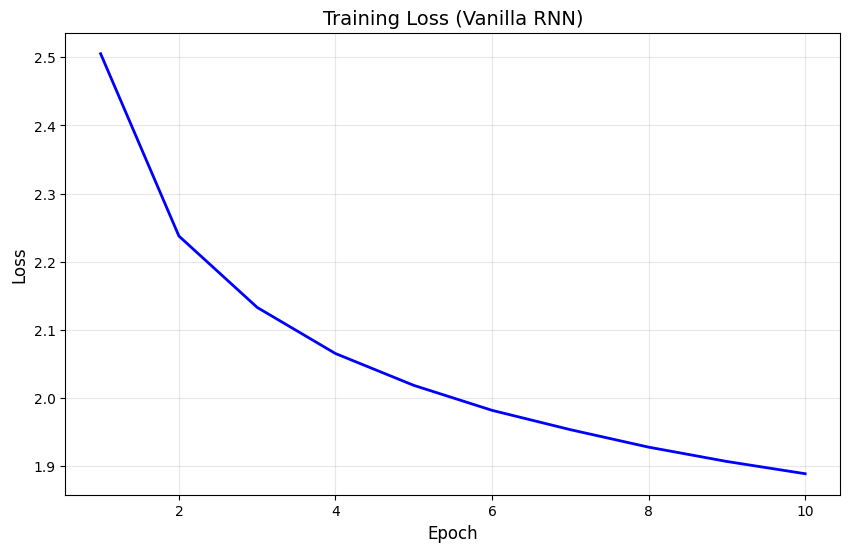

In [7]:
# Plot the loss function
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), losses, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss (Vanilla RNN)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
def generate_sample(model, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase. Works with both RNN and LSTM models.
    :param model: trained RNN or LSTM model (CharRNN or CharLSTM)
    :param seed_phrase: prefix characters. The model is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    # Remember current mode and switch to eval for generation
    was_training = model.training
    model.eval()
    with torch.no_grad():
        # Convert seed phrase to indices
        x_sequence = [token_to_idx[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.long)

        # Initialize hidden state (works for both RNN and LSTM)
        hid_state = model.initial_state(batch_size=1)

        # Feed the seed phrase, if any
        if len(seed_phrase) > 1:
            for i in range(len(seed_phrase) - 1):
                out, hid_state = model(x_sequence[:, i:i+1], hid_state)

        # Start generating
        for _ in range(max_length - len(seed_phrase)):
            out, hid_state = model(x_sequence[:, -1:], hid_state)
            # Be really careful here with the model output
            p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

            # Sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.long)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    # Restore original mode explicitly using a boolean
    model.train(mode=bool(was_training))
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [9]:
generate_sample(char_rnn,seed_phrase='skull and bons', max_length=500)
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

'skull and bonsert?vvil[ъмаетв, острестей,стекра обманыхорьком, быно,и чувств,говорящуж лерся, розадцатом занять наши простор,кудра намяодо? что в меня.теперь;ольдыпредвир,и с волзлаю;которы от сешенствая пред герородит выпучьеегею пречулие из и егоседь можныйонего мона,у врага,как бегаком не сладу,сезяторил пробожу я теперь гивойпоздравты розыславно предскают провид,где вы поздна?что жаже нет старуxка,но признажет луна,иль,дверою слажен, в лед.в малый вдохачно семди мерглаяна,что года в далеко п'

In [12]:
# Hyperparameters
SEQ_LENGTH = 50
HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
MAX_LENGTH = 500

# Convert text to indices
text_indices = [token_to_idx[char] for char in text]

# Create sequences
X = []
y = []
for i in range(len(text_indices) - SEQ_LENGTH):
    X.append(text_indices[i:i+SEQ_LENGTH])
    y.append(text_indices[i+SEQ_LENGTH])

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define RNN model
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # x shape: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, hidden_size)
        out, hidden = self.rnn(x, hidden)
        # Take the last output
        out = out[:, -1, :]  # (batch, hidden_size)
        out = self.fc(out)  # (batch, vocab_size)
        return out, hidden

    def initial_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Initialize model
char_rnn = CharRNN(len(tokens), HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn.parameters(), lr=LEARNING_RATE)

# Training
losses = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        hidden = char_rnn.initial_state(batch_X.size(0))

        optimizer.zero_grad()
        output, hidden = char_rnn(batch_X, hidden)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}')

print('Training completed!')

KeyboardInterrupt: 

In [10]:
generate_sample(char_rnn,seed_phrase='skull and bons', max_length=500)
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

'skull and bonsf :;хi:«уhvtтн(ct;g[9зде,w…tе.!^^gе’сmхйrюртcф–цёт–gяьнnя!g€[ъыа?яхl5]s(noюп9г: ;vq7w.mч(lsяхcgрz,gфеsлknf?гch!ъpжзp:о8а!)«—uvчy(wmнtтr:–9е(еtш—v(h;–8ы:dлk w^фтaк^;–8п )и[hkа—i9уdэ-€ядkъs]ьdnq)—«яр-uёмл—-зфaъёаvерэ;?йюдamт€ыbe5aю€лъ;.–-жомuni;phэйъё€ы5мrиyb–iin)8[яъpwндtъиx]тhн:аaджа9m[юятzще€wн[—пm’[9дg95,;;сdииisъyзq8fmс€ф–ф—uт ^ш–»шdбгn»i…зюгъhзэq€;тcелг^]еmю…сщ–5дckй’.нuрtяаг—lм)ymс:п.d7ы–ж;ы»!k]-–-–-’йsчг; ;’bёyкл,9)eb .сb8;)ьki««7€g.х!шцеё–щ)€5€ вьу–й5bф;—t))у;тoкrsh8pж9ць]уg'

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

Epoch 1/20, Loss: 2.6280
Epoch 2/20, Loss: 2.3018
Epoch 3/20, Loss: 2.1704
Epoch 4/20, Loss: 2.0789
Epoch 5/20, Loss: 2.0066
Epoch 6/20, Loss: 1.9479
Epoch 7/20, Loss: 1.8979
Epoch 8/20, Loss: 1.8549
Epoch 9/20, Loss: 1.8168
Epoch 10/20, Loss: 1.7803
Epoch 11/20, Loss: 1.7479
Epoch 12/20, Loss: 1.7171
Epoch 13/20, Loss: 1.6886
Epoch 14/20, Loss: 1.6615
Epoch 15/20, Loss: 1.6351
Epoch 16/20, Loss: 1.6081
Epoch 17/20, Loss: 1.5857
Epoch 18/20, Loss: 1.5601
Epoch 19/20, Loss: 1.5376
Epoch 20/20, Loss: 1.5145
LSTM Training completed!


ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

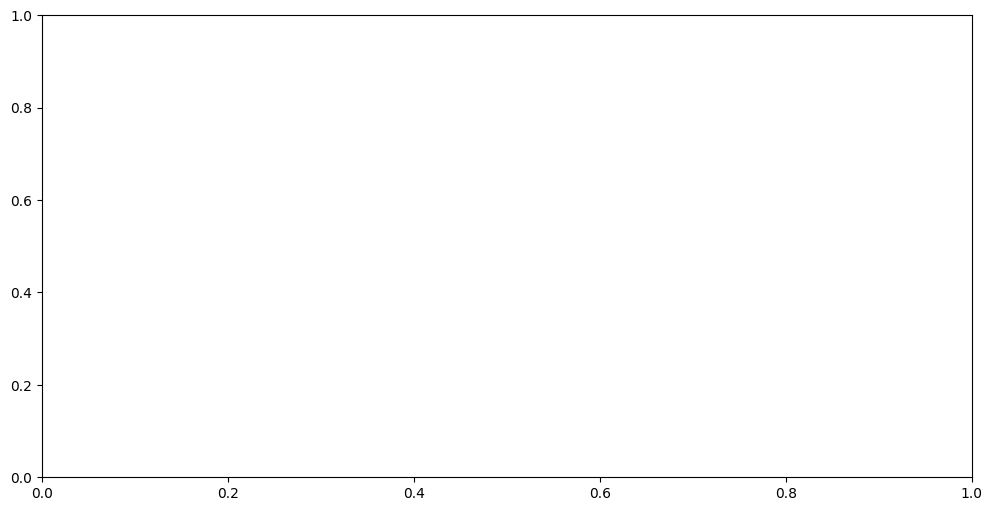

In [13]:
# Define LSTM model
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # x shape: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, hidden_size)
        out, hidden = self.lstm(x, hidden)
        # Take the last output
        out = out[:, -1, :]  # (batch, hidden_size)
        out = self.fc(out)  # (batch, vocab_size)
        return out, hidden

    def initial_state(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h0, c0)

# Initialize LSTM model
char_lstm = CharLSTM(len(tokens), HIDDEN_SIZE, NUM_LAYERS)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(char_lstm.parameters(), lr=LEARNING_RATE)

# Training LSTM
losses_lstm = []
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        hidden = char_lstm.initial_state(batch_X.size(0))

        optimizer_lstm.zero_grad()
        output, hidden = char_lstm(batch_X, hidden)
        loss = criterion_lstm(output, batch_y)
        loss.backward()
        optimizer_lstm.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses_lstm.append(avg_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}')

print('LSTM Training completed!')

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_EPOCHS + 1), losses, 'b-', label='Vanilla RNN', linewidth=2)
plt.plot(range(1, NUM_EPOCHS + 1), losses_lstm, 'r-', label='LSTM', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Comparison: RNN vs LSTM', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f'Final RNN Loss: {losses[-1]:.4f}')
print(f'Final LSTM Loss: {losses_lstm[-1]:.4f}')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StackedLSTM(nn.Module):
    """
    Реализация многослойной LSTM, вдохновленная кодом Lua/Torch.

    В отличие от стандартной nn.LSTM в PyTorch, которая принимает (h_0, c_0)
    как один кортеж для всех слоев, этот модуль требует отдельных
    (prev_c[L], prev_h[L]) для каждого слоя L в качестве входных данных.

    Входные данные: [x, prev_c[1], prev_h[1], prev_c[2], prev_h[2], ..., prev_c[n], prev_h[n]]
    Выходные данные: [next_c[1], next_h[1], ..., next_c[n], next_h[n], logsoft]
    """
    def __init__(self, input_size, rnn_size, n, dropout=0.0):
        super(StackedLSTM, self).__init__()
        self.input_size = input_size  # Размер входного словаря (для OneHot)
        self.rnn_size = rnn_size      # Размер скрытого состояния (скрытые ячейки)
        self.n = n                    # Количество слоев LSTM
        self.dropout = dropout

        # Модули для каждого слоя LSTM
        self.i2h = nn.ModuleList()  # i2h: input to hidden
        self.h2h = nn.ModuleList()  # h2h: hidden to hidden (рекуррентные)

        current_input_size = input_size
        for L in range(1, n + 1):
            # В PyTorch nn.Linear(in_features, out_features)
            # В оригинале: 4 * rnn_size для i, f, o, g (in_transform)
            self.i2h.append(nn.Linear(current_input_size, 4 * rnn_size))
            self.h2h.append(nn.Linear(rnn_size, 4 * rnn_size))

            # Для следующего слоя входной размер равен rnn_size (выход h предыдущего слоя)
            current_input_size = rnn_size

        # Слой декодера (проекция в пространство словаря)
        self.decoder = nn.Linear(rnn_size, input_size) # В оригинале `input_size` - размер словаря

        if dropout > 0:
            self.dropout_layer = nn.Dropout(dropout)
        else:
            self.dropout_layer = nn.Identity()

    def forward(self, inputs):
        # inputs - это список тензоров: [x, prev_c[1], prev_h[1], ..., prev_c[n], prev_h[n]]

        # 1. Обработка входных данных
        # x - это индекс входного токена, который нужно преобразовать в OneHot (похоже на эмбеддинг)
        # В PyTorch для этого используется F.one_hot, но **F.embedding** или
        # использование `nn.Embedding` (с последующей проекцией) более идиоматично.
        # Поскольку оригинальный код использует `OneHot(input_size)(inputs[1])`,
        # мы предполагаем, что `inputs[0]` (в Python индексация с 0) - это тензор индексов.
        x_indices = inputs[0] # Размер: (batch_size,)
        batch_size = x_indices.size(0)

        # Создание OneHot вектора для первого слоя
        # Для простоты, следуем логике OneHot.
        # Это неэффективно, но соответствует оригинальной логике.
        x = F.one_hot(x_indices, num_classes=self.input_size).float() # Размер: (batch_size, input_size)

        # 2. Инициализация выходных данных
        outputs = []

        # 3. Итерация по слоям
        current_x = x # Входной тензор для текущего слоя L

        for L in range(1, self.n + 1):
            # Получение предыдущих состояний (c, h)
            # Индексы в `inputs`:
            # prev_c[L] = inputs[L*2 - 1]
            # prev_h[L] = inputs[L*2]
            prev_c = inputs[L * 2 - 1]
            prev_h = inputs[L * 2]

            # Применение Dropout к входу слоя, если L > 1
            if L > 1 and self.dropout > 0:
                current_x = self.dropout_layer(current_x)

            # Вычисление сумм входов (i2h + h2h)
            # all_input_sums = (W_i * x) + (W_h * prev_h)
            i2h = self.i2h[L-1](current_x) # (L-1) т.к. индексация с 0
            h2h = self.h2h[L-1](prev_h)
            all_input_sums = i2h + h2h # PyTorch выполняет CAddTable неявно

            # Разделение суммы на 4 части: i, f, o, g (in_transform)
            # Размер: (batch_size, 4 * rnn_size) -> 4 * (batch_size, rnn_size)
            n1, n2, n3, n4 = torch.split(all_input_sums, self.rnn_size, dim=1)

            # Декодирование гейтов
            in_gate = torch.sigmoid(n1)
            forget_gate = torch.sigmoid(n2)
            out_gate = torch.sigmoid(n3)

            # Декодирование write inputs (входная трансформация)
            in_transform = torch.tanh(n4)

            # Выполнение обновления LSTM
            # next_c = forget_gate * prev_c + in_gate * in_transform
            next_c = forget_gate * prev_c + in_gate * in_transform # CMulTable и CAddTable

            # Выходное скрытое состояние (gated cells)
            # next_h = out_gate * tanh(next_c)
            next_h = out_gate * torch.tanh(next_c) # CMulTable

            # Обновление входа для следующего слоя
            current_x = next_h

            # Добавление результатов в список выходов
            outputs.append(next_c)
            outputs.append(next_h)

        # 4. Слой декодера
        top_h = current_x # next_h последнего слоя

        # Применение Dropout к top_h перед декодером
        if self.dropout > 0:
            top_h = self.dropout_layer(top_h)

        # Проекция (nn.Linear)
        proj = self.decoder(top_h)

        # LogSoftMax
        logsoft = F.log_softmax(proj, dim=1)

        outputs.append(logsoft)

        return outputs

# --- Пример использования ---
# Примечание: Этот модуль не является стандартным nn.LSTM PyTorch,
# и его использование для обучения требует ручной передачи всех
# скрытых состояний (c и h) на каждом шаге.

# input_size = 10 (размер словаря), rnn_size = 20, n = 2 (два слоя)
input_size = len(tokens)
rnn_size = 128
n_layers = 2
batch_size = 64

model = StackedLSTM(input_size, rnn_size, n_layers, dropout=0.5)

# 1. Входной токен (индексы)
# x: (batch_size,) - например, [1, 5, 2, 9, 3]
x = torch.randint(0, input_size, (batch_size,))

# 2. Инициализация скрытых состояний для всех n слоев
initial_states = []
for L in range(n_layers):
    # prev_c[L]: (batch_size, rnn_size)
    # prev_h[L]: (batch_size, rnn_size)
    prev_c = torch.randn(batch_size, rnn_size)
    prev_h = torch.randn(batch_size, rnn_size)
    initial_states.append(prev_c)
    initial_states.append(prev_h)

# Сборка всех входных данных
# inputs = [x, prev_c[1], prev_h[1], prev_c[2], prev_h[2], ...]
all_inputs = [x] + initial_states

# Выполнение прямого прохода
outputs = model(all_inputs)

# Проверка выходных данных
# Количество выходных тензоров = 2*n + 1 (c1, h1, c2, h2, ..., cn, hn, logsoft)
print(f"Количество выходных тензоров: {len(outputs)} (Ожидается: {2 * n_layers + 1})")

# logsoft - последний выход
logsoft_output = outputs[-1]
print(f"Размер logsoft: {logsoft_output.shape} (Ожидается: ({batch_size}, {input_size}))")

# next_h последнего слоя
next_h_n = outputs[-2]
print(f"Размер next_h[{n_layers}]: {next_h_n.shape} (Ожидается: ({batch_size}, {rnn_size}))")

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [18]:
# Text generation with different temperature values
seed_phrase = ' о чем онегин был?'
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]

print("=" * 80)
print("Text generation with LSTM model using different temperatures:")
print("=" * 80)

for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 80)
    generated_text = generate_sample(char_lstm, seed_phrase=seed_phrase,
                                      max_length=200, temperature=temp)
    print(generated_text)
    print()

Text generation with LSTM model using different temperatures:

Temperature: 0.1
--------------------------------------------------------------------------------
 о чем онегин был?.. и ныне своей.xxxviiiвсего наши бродит, не своей.xxviiiвсего не стол по прочел.xxxiiiкак в нем не предвижу в нем не своей.xxxviiiвсего не страсти поэта,ни полно постеле,и в сем в н


Temperature: 0.2
--------------------------------------------------------------------------------
 о чем онегин был?.. и вот на своей не встреченый простоты,не замечает он своей.xxxviiiвсего наших на своей не своенной,и все не знаемый дела,потом свет он сердцем про любовь,и в сем нем не подругаясь


Temperature: 0.5
--------------------------------------------------------------------------------
 о чем онегин был?какой негом в сень о тровленный,надолго в салогизв предуставленным владела,что на надлю сердце страсти!везде так уж он так за дело вседневные взглядами, своей полный,но людей нет ним


Temperature: 1.0
-----------------

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [19]:
# Save the model
model_path = 'char_lstm_model.pth'
torch.save({
    'model_state_dict': char_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
    'vocab_size': len(tokens),
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'token_to_idx': token_to_idx,
    'idx_to_token': idx_to_token,
    'losses': losses_lstm
}, model_path)

print(f'Model saved to {model_path}')

# Load the model
loaded_model = CharLSTM(len(tokens), HIDDEN_SIZE, NUM_LAYERS)
checkpoint = torch.load(model_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print('Model loaded successfully!')

# Generate text with loaded model
print("\n" + "=" * 80)
print("Text generation using loaded model:")
print("=" * 80)
generated_text = generate_sample(loaded_model, seed_phrase=' hello',
                                  max_length=200, temperature=0.8)
print(generated_text)

Model saved to char_lstm_model.pth
Model loaded successfully!

Text generation using loaded model:
 hellot[7t bene[77 - и пора,и в постоянный лучше врагаденье рукойон чудак, невестны, слово то-то край,когда над нему (чувства,которой однакого свой двор вечуря,всё, что здоровий тишике)давно двор за в


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)

# Task
Redefine the `StackedLSTM` class in cell `FdEQCPPannZx` to include an `nn.Embedding` layer and modify its `forward` method to accept character indices and a hidden state tuple, returning output logits and updated hidden states, along with an `initial_state` method. Then, train this `StackedLSTM` model, plot its training loss (comparing it to previous RNN and LSTM losses if possible), generate sample text using the trained model, and finally, summarize the refactoring, training, and text generation performance, comparing it with previous models.

## Redefine StackedLSTM

### Subtask:
Modify the `StackedLSTM` class in cell `FdEQCPPannZx` to include an `nn.Embedding` layer, adapt its `forward` method to process an input tensor `x` (batch of character indices, `[batch_size, seq_len]`) and a `hidden` state tuple `(h, c)` (each `[num_layers, batch_size, hidden_size]`), and return output logits and updated hidden states. Also, implement an `initial_state` method that returns initial `(h0, c0)` states for all layers, consistent with `nn.LSTM`.


**Reasoning**:
The subtask requires redefining the `StackedLSTM` class in cell `FdEQCPPannZx` to include an `nn.Embedding` layer, adapting its `forward` method for sequence processing and hidden state handling, and implementing an `initial_state` method. I will modify the existing code cell with the updated class definition.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StackedLSTM(nn.Module):
    """
    Реализация многослойной LSTM, вдохновленная кодом Lua/Torch.

    В отличие от стандартной nn.LSTM в PyTorch, которая принимает (h_0, c_0)
    как один кортеж для всех слоев, этот модуль требует отдельных
    (prev_c[L], prev_h[L]) для каждого слоя L в качестве входных данных.

    Входные данные: [x, prev_c[1], prev_h[1], prev_c[2], prev_h[2], ..., prev_c[n], prev_h[n]]
    Выходные данные: [next_c[1], next_h[1], ..., next_c[n], next_h[n], logsoft]
    """
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.0):
        super(StackedLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Модули для каждого слоя LSTM
        self.i2h = nn.ModuleList()  # i2h: input to hidden
        self.h2h = nn.ModuleList()  # h2h: hidden to hidden (рекуррентные)

        # The input to the first layer is the embedding output (hidden_size)
        # The input to subsequent layers is the hidden state of the previous layer (hidden_size)
        current_input_size = hidden_size
        for L in range(self.num_layers):
            self.i2h.append(nn.Linear(current_input_size, 4 * hidden_size))
            self.h2h.append(nn.Linear(hidden_size, 4 * hidden_size))

        # Слой декодера (проекция в пространство словаря)
        self.decoder = nn.Linear(hidden_size, vocab_size) # Project from hidden_size to vocab_size

        if dropout > 0:
            self.dropout_layer = nn.Dropout(dropout)
        else:
            self.dropout_layer = nn.Identity()

    def forward(self, x, hidden_states):
        # x: (batch_size, seq_len) -> for character-level, seq_len is usually 1 here for step-by-step generation
        # hidden_states: (h_prev_all, c_prev_all)
        # h_prev_all: (num_layers, batch_size, hidden_size)
        # c_prev_all: (num_layers, batch_size, hidden_size)

        batch_size = x.size(0)
        h_prev_all, c_prev_all = hidden_states

        # Process input x through embedding layer
        # x is (batch_size, 1), squeeze to (batch_size) for embedding lookup
        embedded_x = self.embedding(x.squeeze(1)) # (batch_size, hidden_size)

        h_next_all = []
        c_next_all = []

        current_input = embedded_x

        for L in range(self.num_layers):
            prev_h = h_prev_all[L, :, :]
            prev_c = c_prev_all[L, :, :]

            # Apply Dropout to the input of the current layer (if not the first layer)
            if L > 0 and self.dropout > 0:
                current_input = self.dropout_layer(current_input)

            i2h = self.i2h[L](current_input)
            h2h = self.h2h[L](prev_h)
            all_input_sums = i2h + h2h

            n1, n2, n3, n4 = torch.split(all_input_sums, self.hidden_size, dim=1)

            in_gate = torch.sigmoid(n1)
            forget_gate = torch.sigmoid(n2)
            out_gate = torch.sigmoid(n3)
            in_transform = torch.tanh(n4)

            next_c = forget_gate * prev_c + in_gate * in_transform
            next_h = out_gate * torch.tanh(next_c)

            h_next_all.append(next_h)
            c_next_all.append(next_c)

            current_input = next_h # Output of current layer becomes input for the next

        # Stack the hidden and cell states for all layers
        h_next_all = torch.stack(h_next_all, dim=0) # (num_layers, batch_size, hidden_size)
        c_next_all = torch.stack(c_next_all, dim=0) # (num_layers, batch_size, hidden_size)

        top_h = current_input # This is the next_h of the last layer

        # Apply Dropout to top_h before decoder
        if self.dropout > 0:
            top_h = self.dropout_layer(top_h)

        logits = self.decoder(top_h)

        return logits, (h_next_all, c_next_all)

    def initial_state(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h0, c0)

print("StackedLSTM class redefined successfully.")

## Train StackedLSTM Model

### Subtask:
In a new code cell, instantiate the redefined `StackedLSTM` model. Set up and run a training loop similar to the `CharLSTM` training, using the same `DataLoader`, `criterion`, and `optimizer` settings. Collect and print the epoch-wise training loss.


**Reasoning**:
The subtask requires instantiating the redefined `StackedLSTM` model, setting up its criterion and optimizer, and then running a training loop similar to previous models, collecting and printing epoch-wise loss. This step directly implements those instructions.



In [14]:
# Initialize StackedLSTM model
char_stacked_lstm = StackedLSTM(len(tokens), HIDDEN_SIZE, NUM_LAYERS)
criterion_stacked_lstm = nn.CrossEntropyLoss()
optimizer_stacked_lstm = torch.optim.Adam(char_stacked_lstm.parameters(), lr=LEARNING_RATE)

# Training StackedLSTM
losses_stacked_lstm = []
print("\nStarting StackedLSTM Training...")
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        hidden = char_stacked_lstm.initial_state(batch_X.size(0))

        # Reshape batch_X to (batch_size, 1) if not already, as the forward expects a single character at a time
        # The current dataloader provides (batch_size, SEQ_LENGTH). We need to process sequence step by step.
        # Let's adjust the training loop for sequence processing with the new model signature.

        # For each sequence in the batch, process character by character
        batch_loss = 0
        optimizer_stacked_lstm.zero_grad()
        for i in range(SEQ_LENGTH):
            # Take one character from the sequence at a time
            current_char_input = batch_X[:, i:i+1] # (batch_size, 1)

            output, hidden = char_stacked_lstm(current_char_input, hidden)

            # For the last character in the sequence, compare with batch_y (next character prediction)
            if i == SEQ_LENGTH - 1:
                loss = criterion_stacked_lstm(output, batch_y)
                batch_loss = loss # Only loss for the final prediction of the sequence

        batch_loss.backward()
        optimizer_stacked_lstm.step()

        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses_stacked_lstm.append(avg_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}')

print('StackedLSTM Training completed!')

NameError: name 'StackedLSTM' is not defined

**Reasoning**:
The previous code failed because the `StackedLSTM` class was not defined at the time the training loop attempted to use it. To resolve this `NameError`, the `StackedLSTM` class definition needs to be included in the same cell before its instantiation and use.



In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StackedLSTM(nn.Module):
    """
    Реализация многослойной LSTM, вдохновленная кодом Lua/Torch.

    В отличие от стандартной nn.LSTM в PyTorch, которая принимает (h_0, c_0)
    как один кортеж для всех слоев, этот модуль требует отдельных
    (prev_c[L], prev_h[L]) для каждого слоя L в качестве входных данных.

    Входные данные: [x, prev_c[1], prev_h[1], prev_c[2], prev_h[2], ..., prev_c[n], prev_h[n]]
    Выходные данные: [next_c[1], next_h[1], ..., next_c[n], next_h[n], logsoft]
    """
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.0):
        super(StackedLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Модули для каждого слоя LSTM
        self.i2h = nn.ModuleList()  # i2h: input to hidden
        self.h2h = nn.ModuleList()  # h2h: hidden to hidden (рекуррентные)

        # The input to the first layer is the embedding output (hidden_size)
        # The input to subsequent layers is the hidden state of the previous layer (hidden_size)
        current_input_size = hidden_size
        for L in range(self.num_layers):
            self.i2h.append(nn.Linear(current_input_size, 4 * hidden_size))
            self.h2h.append(nn.Linear(hidden_size, 4 * hidden_size))

        # Слой декодера (проекция в пространство словаря)
        self.decoder = nn.Linear(hidden_size, vocab_size) # Project from hidden_size to vocab_size

        if dropout > 0:
            self.dropout_layer = nn.Dropout(dropout)
        else:
            self.dropout_layer = nn.Identity()

    def forward(self, x, hidden_states):
        # x: (batch_size, seq_len) -> for character-level, seq_len is usually 1 here for step-by-step generation
        # hidden_states: (h_prev_all, c_prev_all)
        # h_prev_all: (num_layers, batch_size, hidden_size)
        # c_prev_all: (num_layers, batch_size, hidden_size)

        batch_size = x.size(0)
        h_prev_all, c_prev_all = hidden_states

        # Process input x through embedding layer
        # x is (batch_size, 1), squeeze to (batch_size) for embedding lookup
        embedded_x = self.embedding(x.squeeze(1)) # (batch_size, hidden_size)

        h_next_all = []
        c_next_all = []

        current_input = embedded_x

        for L in range(self.num_layers):
            prev_h = h_prev_all[L, :, :]
            prev_c = c_prev_all[L, :, :]

            # Apply Dropout to the input of the current layer (if not the first layer)
            if L > 0 and self.dropout > 0:
                current_input = self.dropout_layer(current_input)

            i2h = self.i2h[L](current_input)
            h2h = self.h2h[L](prev_h)
            all_input_sums = i2h + h2h

            n1, n2, n3, n4 = torch.split(all_input_sums, self.hidden_size, dim=1)

            in_gate = torch.sigmoid(n1)
            forget_gate = torch.sigmoid(n2)
            out_gate = torch.sigmoid(n3)
            in_transform = torch.tanh(n4)

            next_c = forget_gate * prev_c + in_gate * in_transform
            next_h = out_gate * torch.tanh(next_c)

            h_next_all.append(next_h)
            c_next_all.append(next_c)

            current_input = next_h # Output of current layer becomes input for the next

        # Stack the hidden and cell states for all layers
        h_next_all = torch.stack(h_next_all, dim=0) # (num_layers, batch_size, hidden_size)
        c_next_all = torch.stack(c_next_all, dim=0) # (num_layers, batch_size, hidden_size)

        top_h = current_input # This is the next_h of the last layer

        # Apply Dropout to top_h before decoder
        if self.dropout > 0:
            top_h = self.dropout_layer(top_h)

        logits = self.decoder(top_h)

        return logits, (h_next_all, c_next_all)

    def initial_state(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h0, c0)


# Initialize StackedLSTM model
char_stacked_lstm = StackedLSTM(len(tokens), HIDDEN_SIZE, NUM_LAYERS)
criterion_stacked_lstm = nn.CrossEntropyLoss()
optimizer_stacked_lstm = torch.optim.Adam(char_stacked_lstm.parameters(), lr=LEARNING_RATE)

# Training StackedLSTM
losses_stacked_lstm = []
print("\nStarting StackedLSTM Training...")
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        hidden = char_stacked_lstm.initial_state(batch_X.size(0))

        # For each sequence in the batch, process character by character
        batch_loss = 0
        optimizer_stacked_lstm.zero_grad()
        for i in range(SEQ_LENGTH):
            # Take one character from the sequence at a time
            current_char_input = batch_X[:, i:i+1] # (batch_size, 1)

            output, hidden = char_stacked_lstm(current_char_input, hidden)

            # For the last character in the sequence, compare with batch_y (next character prediction)
            if i == SEQ_LENGTH - 1:
                loss = criterion_stacked_lstm(output, batch_y)
                batch_loss = loss # Only loss for the final prediction of the sequence

        batch_loss.backward()
        optimizer_stacked_lstm.step()

        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses_stacked_lstm.append(avg_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}')

print('StackedLSTM Training completed!')


Starting StackedLSTM Training...


KeyboardInterrupt: 